<a href="https://colab.research.google.com/github/cuzmyk/data_mining/blob/main/pr10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Практическая работа №10. Анализ и сегментация клиентов с помощью алгоритмов кластеризации**

### **Цель работы:**

Разработать систему сегментации клиентов для розничной компании с использованием алгоритмов кластеризации. Это позволит компании лучше понимать своих клиентов, персонализировать маркетинговые кампании и оптимизировать бизнес-процессы.

### **Введение:**

Розничные компании сталкиваются с большим объемом данных о своих клиентах, включая историю покупок, демографическую информацию и поведенческие характеристики. Однако без должного анализа эти данные остаются неиспользованными. Сегментация клиентов позволяет выделить группы с общими характеристиками, чтобы более эффективно таргетировать предложения и улучшить удовлетворенность клиентов.



### **Задачи:**

1. **Сбор и анализ данных о клиентах.**
2. **Предобработка и подготовка данных для моделирования.**
3. **Применение различных алгоритмов кластеризации для сегментации клиентов.**
4. **Оценка качества кластеризации с использованием внутренних и внешних метрик.**
5. **Интерпретация и визуализация результатов.**
6. **Формирование рекомендаций для бизнес-стратегии компании на основе полученных сегментов.**



### **Пошаговое описание рабочего процесса (пайплайна):**

#### **Шаг 1: Сбор и анализ данных**

**1.1. Выбор набора данных:**

- Используйте датасет "Online Retail II" из [UCI Machine Learning Repository](https://www.kaggle.com/datasets/mashlyn/online-retail-ii-uci) или другой открытый набор данных, содержащий информацию о транзакциях клиентов.
- Данные должны включать:
  - Идентификаторы клиентов.
  - Информацию о покупках (товары, количество, стоимость).
  - Дату и время транзакций.
  - Демографические данные (если доступны): возраст, пол, локация и т.д.

**1.2. Первичный анализ данных (EDA):**

- Изучите структуру данных и их распределение.
- Определите основные характеристики данных:
  - Общий объем продаж.
  - Частота покупок по клиентам.
  - Распределение выручки по товарам.
- Выявите тенденции и аномалии.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
import os
import seaborn as sns

In [ ]:
df = pd.read_csv('online_retail_II.csv')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1067371 entries, 0 to 1067370
Data columns (total 8 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   Invoice      1067371 non-null  object 
 1   StockCode    1067371 non-null  object 
 2   Description  1062989 non-null  object 
 3   Quantity     1067371 non-null  int64  
 4   InvoiceDate  1067371 non-null  object 
 5   Price        1067371 non-null  float64
 6   Customer ID  824364 non-null   float64
 7   Country      1067371 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 65.1+ MB


In [ ]:
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

print("Общий объем продаж с 2009 по 2011 года:", df['Quantity'].sum())
df['Year'] = df['InvoiceDate'].dt.year
quantity_year = df.groupby('Year')['Quantity'].sum()

for year, quantity in quantity_year.items():
    print(f"{year} год: {quantity}")

Общий объем продаж с 2009 по 2011 года: 10608492
2009 год: 420088
2010 год: 5354181
2011 год: 4834223


In [ ]:
purchase_frequency = df['Customer ID'].value_counts()
print("Частота покупок по клиентам")
purchase_frequency.head(10)

Частота покупок по клиентам


,count
Customer ID,
17841.0,13097
14911.0,11613
12748.0,7307
14606.0,6709
14096.0,5128
15311.0,4717
14156.0,4130
14646.0,3890
13089.0,3438


In [ ]:
df['Revenue'] = df['Quantity'] * df['Price']

revenue_products = df.groupby('Description')['Revenue'].sum().sort_values(ascending=False)
revenue_products.head(10)

,Revenue
Description,
REGENCY CAKESTAND 3 TIER,327813.65
DOTCOM POSTAGE,322647.47
WHITE HANGING HEART T-LIGHT HOLDER,257533.90
JUMBO BAG RED RETROSPOT,148800.64
PARTY BUNTING,147948.50
ASSORTED COLOUR BIRD ORNAMENT,131413.85
PAPER CHAIN KIT 50'S CHRISTMAS,121662.14
POSTAGE,112341.00
CHILLI LIGHTS,84854.16


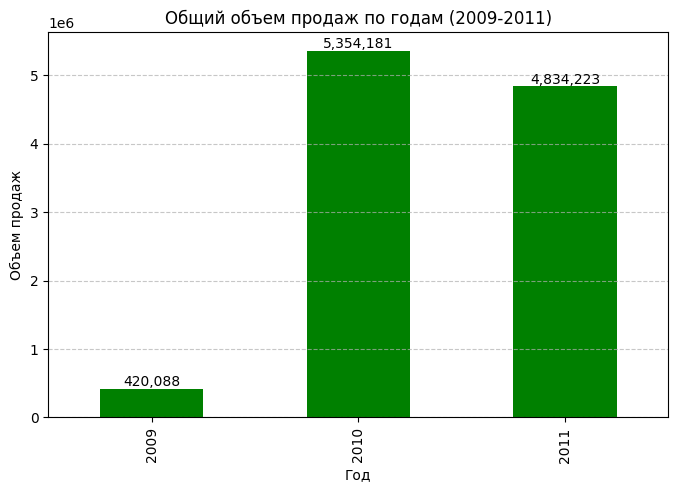

In [ ]:
plt.figure(figsize=(8, 5))
ax = quantity_year.plot(kind='bar', color='green')

for i, value in enumerate(quantity_year):
    plt.text(i, value, f'{value:,}', ha='center', va='bottom', fontsize=10)

plt.title('Общий объем продаж по годам (2009-2011)')
plt.xlabel('Год')
plt.ylabel('Объем продаж')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

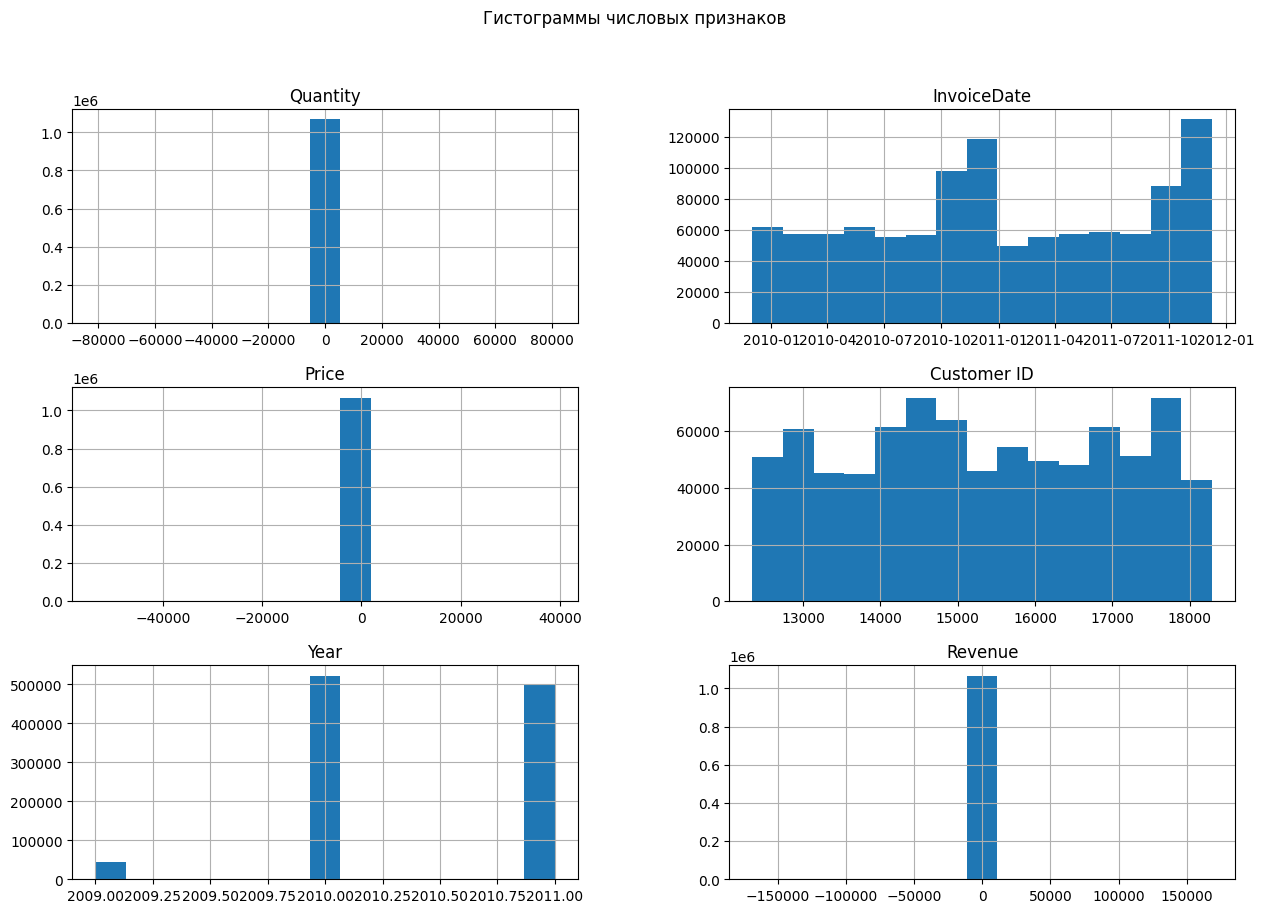

In [ ]:
# Построение гистограмм для каждого числового признака
df.hist(bins=15, figsize=(15, 10))
plt.suptitle('Гистограммы числовых признаков')
plt.show()

#### **Шаг 2: Предобработка данных**

**2.1. Работа с пропущенными значениями:**

- Проанализируйте наличие пропущенных данных.
- Решите, как справиться с ними:
  - Удаление строк/столбцов с пропущенными значениями.
  - Заполнение пропущенных значений средним, медианой или наиболее частым значением.

In [ ]:
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,4382
Quantity,0
InvoiceDate,0
Price,0
Customer ID,243007
Country,0
Year,0
Revenue,0


In [ ]:
df = df.dropna(subset=['Description'])

In [ ]:
df.loc[df['Customer ID'].isnull(), 'Customer ID'] = np.random.randint(10000, 99999, size=df['Customer ID'].isnull().sum())

In [ ]:
df.isnull().sum()

,0
Invoice,0
StockCode,0
Description,0
Quantity,0
InvoiceDate,0
Price,0
Customer ID,0
Country,0
Year,0
Revenue,0


**2.2. Обработка выбросов:**

- Выявите выбросы в данных (например, аномально большие заказы).
- Решите, следует ли их удалить или обработать иным образом.

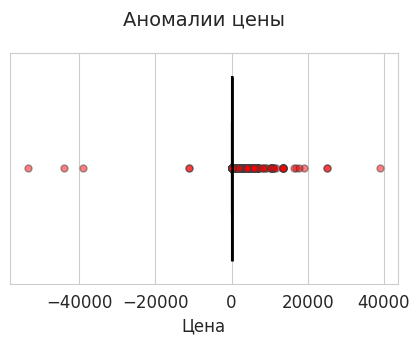

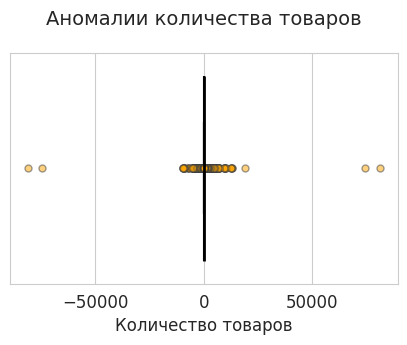

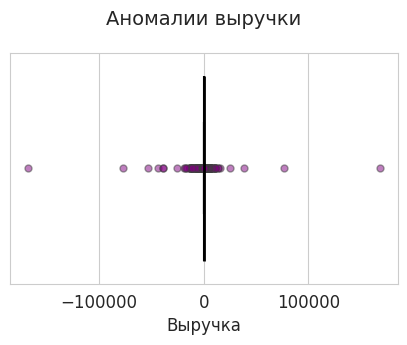

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# График для аномалий цены
plt.figure(figsize=(5, 3))
sns.boxplot(
    x=df['Price'],
    boxprops=dict(facecolor='lightblue', edgecolor='black', linewidth=1.5),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    flierprops=dict(marker='o', markersize=5, markerfacecolor='red', alpha=0.5),
    medianprops=dict(color='black', linewidth=2)
)
plt.title('Аномалии цены', fontsize=14, pad=20)
plt.xlabel('Цена', fontsize=12)
plt.show()

# График для аномалий количества товаров
plt.figure(figsize=(5, 3))
sns.boxplot(
    x=df['Quantity'],
    boxprops=dict(facecolor='lightgreen', edgecolor='black', linewidth=1.5),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    flierprops=dict(marker='o', markersize=5, markerfacecolor='orange', alpha=0.5),
    medianprops=dict(color='black', linewidth=2)
)
plt.title('Аномалии количества товаров', fontsize=14, pad=20)
plt.xlabel('Количество товаров', fontsize=12)
plt.show()

# График для аномалий выручки
plt.figure(figsize=(5, 3))
sns.boxplot(
    x=df['Revenue'],
    boxprops=dict(facecolor='lightcoral', edgecolor='black', linewidth=1.5),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    flierprops=dict(marker='o', markersize=5, markerfacecolor='purple', alpha=0.5),
    medianprops=dict(color='black', linewidth=2)
)
plt.title('Аномалии выручки', fontsize=14, pad=20)
plt.xlabel('Выручка', fontsize=12)
plt.show()

In [ ]:
df = df[(df['Quantity'] > 0) & (df['Price'] > 0) & (df['Revenue'] > 0)]

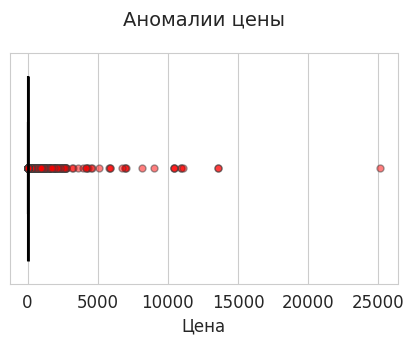

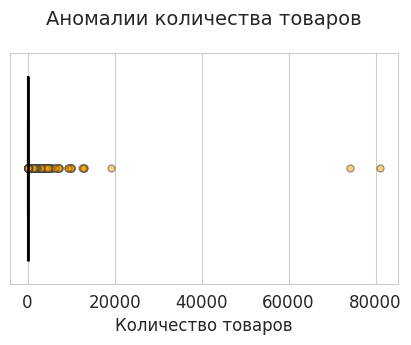

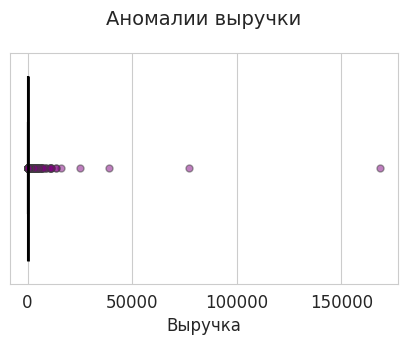

In [ ]:
sns.set_style("whitegrid")
plt.rcParams['font.size'] = 12

# График для аномалий цены
plt.figure(figsize=(5, 3))
sns.boxplot(
    x=df['Price'],
    boxprops=dict(facecolor='lightblue', edgecolor='black', linewidth=1.5),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    flierprops=dict(marker='o', markersize=5, markerfacecolor='red', alpha=0.5),
    medianprops=dict(color='black', linewidth=2)
)
plt.title('Аномалии цены', fontsize=14, pad=20)
plt.xlabel('Цена', fontsize=12)
plt.show()

# График для аномалий количества товаров
plt.figure(figsize=(5, 3))
sns.boxplot(
    x=df['Quantity'],
    boxprops=dict(facecolor='lightgreen', edgecolor='black', linewidth=1.5),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    flierprops=dict(marker='o', markersize=5, markerfacecolor='orange', alpha=0.5),
    medianprops=dict(color='black', linewidth=2)
)
plt.title('Аномалии количества товаров', fontsize=14, pad=20)
plt.xlabel('Количество товаров', fontsize=12)
plt.show()

# График для аномалий выручки
plt.figure(figsize=(5, 3))
sns.boxplot(
    x=df['Revenue'],
    boxprops=dict(facecolor='lightcoral', edgecolor='black', linewidth=1.5),
    whiskerprops=dict(color='black', linewidth=1.5),
    capprops=dict(color='black', linewidth=1.5),
    flierprops=dict(marker='o', markersize=5, markerfacecolor='purple', alpha=0.5),
    medianprops=dict(color='black', linewidth=2)
)
plt.title('Аномалии выручки', fontsize=14, pad=20)
plt.xlabel('Выручка', fontsize=12)
plt.show()

**2.3. Создание новых признаков:**

- Рассчитайте Recency, Frequency, Monetary Value (RFM-анализ):
  - **Recency (давность):** Время с момента последней покупки.
  - **Frequency (частота):** Количество покупок за определенный период.
  - **Monetary (сумма):** Общая сумма покупок.
- Создайте дополнительные признаки, такие как средний чек, предпочтительные категории товаров и т.д.

In [ ]:
import datetime as dt

In [ ]:
df = df[df['Revenue'] > 0]

RFM_data = df[['Customer ID', 'Invoice', 'InvoiceDate', 'Revenue']]

NOW = dt.datetime(2011, 12, 10)

RFM_table = RFM_data.groupby('Customer ID').agg({
    'InvoiceDate': lambda x: (NOW - x.max()).days,  # Recency (давность)
    'Invoice': lambda x: x.nunique(),  # Frequency (частота)
    'Revenue': lambda x: x.sum()       # Monetary (сумма)
})

# Приведение столбца Recency к целочисленному типу
RFM_table['InvoiceDate'] = RFM_table['InvoiceDate'].astype(int)

RFM_table.rename(columns={
    'InvoiceDate': 'Recency',
    'Invoice': 'Frequency',
    'Revenue': 'Monetary'
}, inplace=True)

negative_values = RFM_table[(RFM_table['Recency'] < 0) | (RFM_table['Frequency'] < 0) | (RFM_table['Monetary'] < 0)]

if negative_values.empty:
    print("Проверка завершена: отрицательных значений в RFM-таблице нет.")
else:
    print("Обнаружены отрицательные значения:")
    print(negative_values)

RFM_table.head(10)

Проверка завершена: отрицательных значений в RFM-таблице нет.


,Recency,Frequency,Monetary
Customer ID,,,
10000.0,10,5,92.12
10001.0,227,5,50.84
10002.0,46,7,106.45
10003.0,142,3,33.17
10004.0,114,2,12.35
10005.0,64,2,6.00
10006.0,10,2,8.30
10007.0,365,2,12.86
10008.0,544,3,64.29


In [ ]:
# Средний чек
RFM_table['average_bill'] = RFM_table['Monetary'] / RFM_table['Frequency']

# Предпочтительные категории товаров
preferred_categories = df.groupby(['Customer ID', 'Description'])['Quantity'].sum().reset_index()
preferred_categories = preferred_categories.loc[
    preferred_categories.groupby('Customer ID')['Quantity'].idxmax()
]
preferred_categories = preferred_categories.rename(columns={'Description': 'preferred_category'})

RFM_table = RFM_table.merge(preferred_categories[['Customer ID', 'preferred_category']], on='Customer ID', how='left')

In [ ]:
RFM_table.head()

,Customer ID,Recency,Frequency,Monetary,average_bill,preferred_category
0,10000.0,10,5,92.12,18.424000,EMBOSSED GLASS TEALIGHT HOLDER
1,10001.0,227,5,50.84,10.168000,DOORMAT 3 SMILEY CATS
2,10002.0,46,7,106.45,15.207143,MIRROR MOSAIC VOTIVE HOLDER
3,10003.0,142,3,33.17,11.056667,SCANDINAVIAN PAISLEY PICNIC BAG
4,10004.0,114,2,12.35,6.175000,SET/6 RED SPOTTY PAPER CUPS


In [ ]:
df = df.merge(RFM_table, on='Customer ID', how='left')
df.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,Year,Revenue,Recency,Frequency,Monetary,average_bill,preferred_category
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,2009,83.4,157,8,2433.28,304.16,"RECORD FRAME 7"" SINGLE SIZE"
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,81.0,157,8,2433.28,304.16,"RECORD FRAME 7"" SINGLE SIZE"
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,2009,81.0,157,8,2433.28,304.16,"RECORD FRAME 7"" SINGLE SIZE"
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,2009,100.8,157,8,2433.28,304.16,"RECORD FRAME 7"" SINGLE SIZE"
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,2009,30.0,157,8,2433.28,304.16,"RECORD FRAME 7"" SINGLE SIZE"


**2.4. Нормализация и масштабирование:**

- Примените стандартизацию или нормализацию к числовым признакам для приведения их к единому масштабу.
- Объясните выбор метода масштабирования.

In [ ]:
from sklearn.preprocessing import StandardScaler

In [ ]:
features = ['Recency', 'Frequency', 'Monetary', 'average_bill', 'Revenue', 'Price']
scaler = StandardScaler()
df[features] = scaler.fit_transform(df[features])

#### **Шаг 3: Применение алгоритмов кластеризации**

**3.1. Выбор алгоритмов:**

- **K-средних (K-Means):** Для разбиения данных на k кластеров на основе эврестического подхода.
- **Иерархическая кластеризация:** Для выявления вложенной структуры кластеров.
- **DBSCAN и OPTICS:** Для обнаружения кластеров произвольной формы и выявления выбросов.

**3.2. Определение оптимального количества кластеров:**

- Для K-Means и иерархической кластеризации используйте:
  - **Метод локтя (Elbow Method):** Постройте график зависимости суммы квадратов внутрикластерных расстояний от числа кластеров.
  - **Коэффициент силуэта:** Рассчитайте для различных значений k и выберите оптимальное.

**3.3. Применение алгоритмов:**

- Запустите каждый алгоритм на подготовленных данных.
- Сохраняйте результаты кластеризации для последующего анализа.

In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer

In [ ]:
X = df[features]
K = range(1, 11)

In [ ]:
# Метод локтя (Elbow Method)
inertia = []
for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

In [ ]:
# Определение оптимального K по методу локтя
diff_inertia = np.diff(inertia)
diff_diff_inertia = np.diff(diff_inertia)
elbow_point = np.argmin(diff_diff_inertia) + 2

<ipython-input-30-8cb785ed3ea3>:3: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K, inertia, 'bx-', color='green')


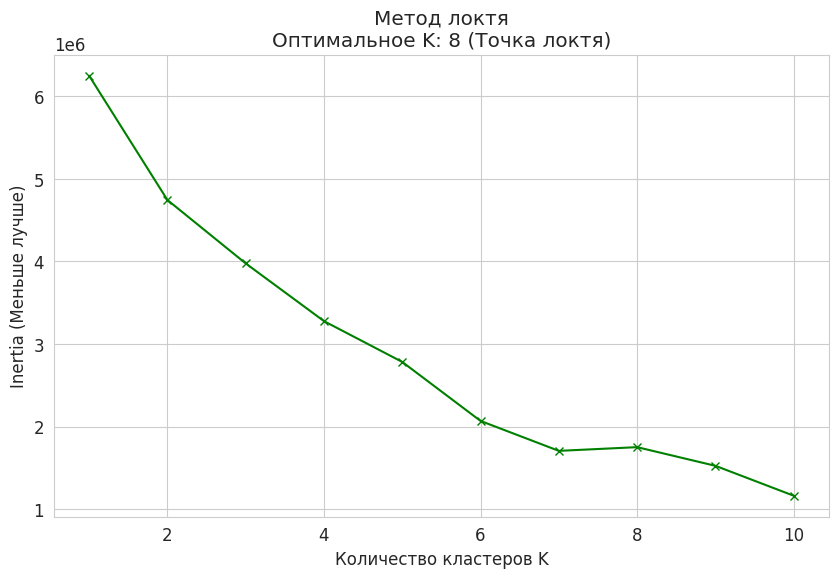

In [ ]:
# График 1: Метод локтя
plt.figure(figsize=(10, 6))
plt.plot(K, inertia, 'bx-', color='green')
plt.xlabel('Количество кластеров K')
plt.ylabel('Inertia (Меньше лучше)')
plt.title(f'Метод локтя\nОптимальное K: {elbow_point} (Точка локтя)')
plt.grid(True)
plt.show()

<ipython-input-31-e2b93fbcb013>:17: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bx-" (-> color='b'). The keyword argument will take precedence.
  plt.plot(K_silhouette, silhouette_scores, 'bx-', color='green')


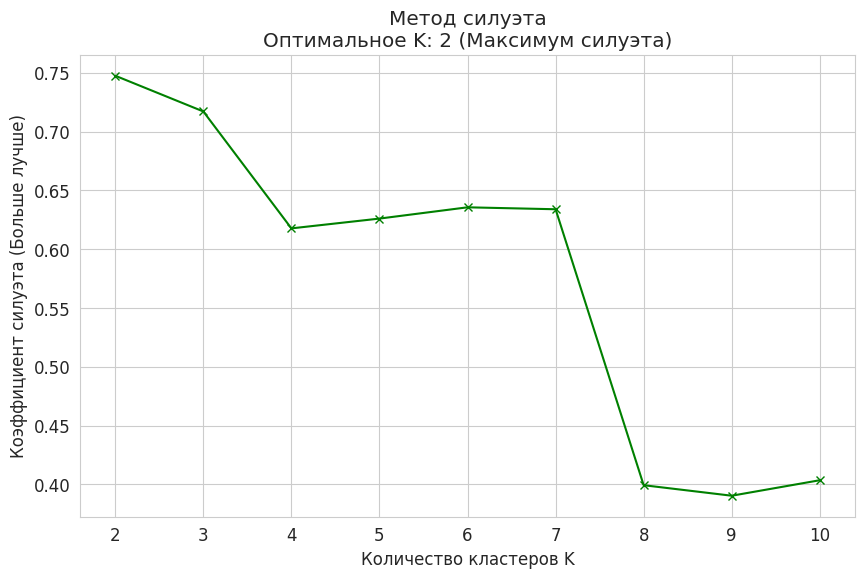

In [ ]:
# Метод силуэта (Silhouette Method)
from sklearn.utils import resample

X_sampled = resample(X, n_samples=30000, random_state=42)
silhouette_scores = []
K_silhouette = range(2, 11)
for k in K_silhouette:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_sampled)
    score = silhouette_score(X_sampled, labels)
    silhouette_scores.append(score)

# Определение оптимального K по методу силуэта
optimal_k_silhouette = K_silhouette[np.argmax(silhouette_scores)]

plt.figure(figsize=(10, 6))
plt.plot(K_silhouette, silhouette_scores, 'bx-', color='green')
plt.xlabel('Количество кластеров K')
plt.ylabel('Коэффициент силуэта (Больше лучше)')
plt.title(f'Метод силуэта\nОптимальное K: {optimal_k_silhouette} (Максимум силуэта)')
plt.grid(True)
plt.show()

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, OPTICS, AgglomerativeClustering
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
df_sampled = df.sample(n=30000, random_state=42)

features = ['Recency', 'Frequency', 'Monetary', 'average_bill', 'Revenue', 'Price']
X_sampled = df_sampled[features]

In [ ]:
optimal_k = 6
kmeans = KMeans(n_clusters=optimal_k, random_state=1)
kmeans_labels = kmeans.fit_predict(X_sampled)

file_path_1 = 'kmeans_2.xlsx'
df_sampled.to_excel(file_path_1, index=False)

print(f"Результаты кластеризации сохранены в {file_path_1}")

Результаты кластеризации сохранены в kmeans_2.xlsx


In [ ]:
n_clusters = elbow_point
hierarchical = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_sampled)

df_sampled['hierarchical_cluster'] = hierarchical_labels

file_path_2 = 'hierarchical_2.xlsx'
df_sampled.to_excel(file_path_2, index=False)

print(f"Результаты кластеризации сохранены в {file_path_2}")

Результаты кластеризации сохранены в hierarchical_2.xlsx


In [ ]:
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_sampled)

df_sampled['dbscan_cluster'] = dbscan_labels

file_path_3 = 'dbscan_2.xlsx'
df_sampled.to_excel(file_path_3, index=False)

print(f"Результаты кластеризации с DBSCAN для случайной выборки сохранены в {file_path_3}")

Результаты кластеризации с DBSCAN для случайной выборки сохранены в dbscan_2.xlsx


In [ ]:
optics = OPTICS(min_samples=5, xi=0.05, min_cluster_size=0.05)

optics_labels = optics.fit_predict(X_sampled)

df_sampled['optics_cluster'] = optics_labels

file_path_4 = 'optics.xlsx'
df_sampled.to_excel(file_path_4, index=False)

print(f"Результаты кластеризации с OPTICS для случайной выборки сохранены в {file_path_4}")

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_optics.py:1086: RuntimeWarning: divide by zero encountered in divide
  ratio = reachability_plot[:-1] / reachability_plot[1:]


Результаты кластеризации с OPTICS для случайной выборки сохранены в optics.xlsx


#### **Шаг 4: Оценка качества кластеризации**

**4.1. Внутренние метрики:**

- **Коэффициент силуэта:** Оцените, насколько хорошо объекты расположены внутри кластеров.
- **Индекс Дэвиса-Болдина:** Оцените уровень разделимости кластеров.
- **Индекс Калинского-Харабаза:** Оцените соотношение межкластерной дисперсии к внутрикластерной.

**4.2. Внешние метрики (если доступны истинные метки):**

- **Adjusted Rand Index (ARI):** Сравните полученные кластеры с известными категориями клиентов.
- **Normalized Mutual Information (NMI):** Измерьте общую информацию между распределениями.

**4.3. Сравнение алгоритмов:**

- Составьте таблицу со значениями метрик для каждого алгоритма.
- Определите, какой алгоритм показал наилучшие результаты и почему.

In [ ]:
from sklearn.metrics import (
    silhouette_score,
    calinski_harabasz_score,
    davies_bouldin_score,
    adjusted_rand_score,
    normalized_mutual_info_score,
    v_measure_score
)
from scipy.spatial.distance import cdist, pdist

In [ ]:
# Функция для вычисления индекса Дунна
def dunn_index(X, labels):
    labels = np.array(labels)
    mask = labels != -1
    X = X[mask]
    labels = labels[mask]

    unique_clusters = np.unique(labels)
    clusters = [X[labels == label] for label in unique_clusters]

    min_intercluster = np.inf
    for i in range(len(clusters)):
        for j in range(i + 1, len(clusters)):
            dist = np.min(cdist(clusters[i], clusters[j]))
            if dist < min_intercluster:
                min_intercluster = dist

    max_intracluster = 0
    for cluster in clusters:
        if len(cluster) > 1:
            dist = np.max(pdist(cluster))
            if dist > max_intracluster:
                max_intracluster = dist

    if max_intracluster == 0 or np.isinf(min_intercluster):
        return np.nan
    else:
        return min_intercluster / max_intracluster

# Функция для расчета внутренних метрик
def compute_internal_metrics(X, labels):
    mask = labels != -1
    X_masked = X[mask]
    labels_masked = labels[mask]
    if len(np.unique(labels_masked)) > 1 and len(X_masked) > 0:
        silhouette = silhouette_score(X_masked, labels_masked)
        calinski_harabasz = calinski_harabasz_score(X_masked, labels_masked)
        davies_bouldin = davies_bouldin_score(X_masked, labels_masked)
        dunn = dunn_index(X, labels)
    else:
        silhouette = np.nan
        calinski_harabasz = np.nan
        davies_bouldin = np.nan
        dunn = np.nan
    return {
        'Коэффициент силуэта': silhouette,
        'Индекс Дэвиса-Болдина': davies_bouldin,
        'Индекс Калинского-Харабаза': calinski_harabasz,
        'Индекс Дунна': dunn
    }

# Функция для расчета внешних метрик
def compute_external_metrics(y_true, y_pred):
    mask = y_pred != -1
    y_true_masked = y_true[mask]
    y_pred_masked = y_pred[mask]
    if len(np.unique(y_pred_masked)) > 1 and len(y_true_masked) > 0:
        ari = adjusted_rand_score(y_true_masked, y_pred_masked)
        v_measure = v_measure_score(y_true_masked, y_pred_masked)
        nmi = normalized_mutual_info_score(y_true_masked, y_pred_masked)
    else:
        ari = np.nan
        v_measure = np.nan
        nmi = np.nan
    return {
        'Adjusted Rand Index (ARI)': ari,
        'V-measure': v_measure,
        'Normalized Mutual Information (NMI)': nmi
    }

In [ ]:
metrics_results = {}

metrics_results['KMeans'] = compute_internal_metrics(X_sampled, kmeans_labels)
metrics_results['DBSCAN'] = compute_internal_metrics(X_sampled, dbscan_labels)
metrics_results['Hierarchical'] = compute_internal_metrics(X_sampled, hierarchical_labels)

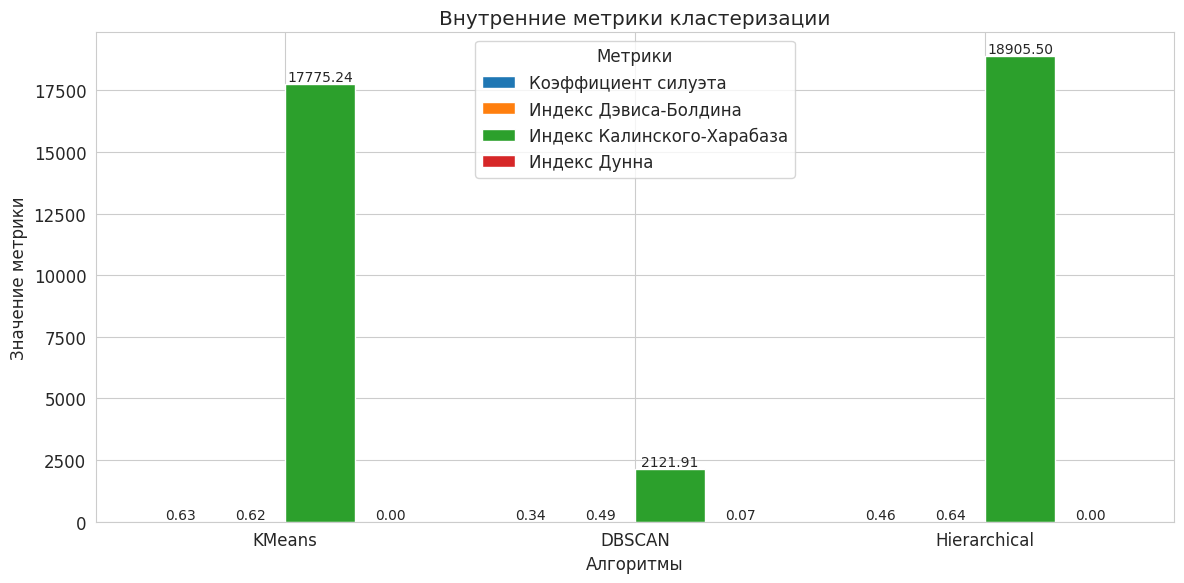

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Алгоритмы и метрики для визуализации
algorithms = list(metrics_results.keys())
internal_metrics = list(metrics_results[algorithms[0]].keys())

# Подготовка данных
def collect_internal_metrics(metrics_results, internal_metrics):
    data = {metric: [metrics_results[algo][metric] for algo in algorithms] for metric in internal_metrics}
    return data

internal_data = collect_internal_metrics(metrics_results, internal_metrics)

# Функция для построения графиков
def plot_internal_metrics(data, algorithms, title):
    x = np.arange(len(algorithms))
    width = 0.2
    offsets = np.arange(len(data)) * width - (len(data) - 1) * width / 2

    plt.figure(figsize=(12, 6))
    for idx, (metric, values) in enumerate(data.items()):
        plt.bar(x + offsets[idx], values, width, label=metric)
        for xi, value in zip(x, values):
            if not np.isnan(value):
                plt.text(xi + offsets[idx], value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

    plt.xticks(x, algorithms)
    plt.xlabel('Алгоритмы')
    plt.ylabel('Значение метрики')
    plt.title(title)
    plt.legend(title="Метрики")
    plt.tight_layout()
    plt.show()

plot_internal_metrics(internal_data, algorithms, "Внутренние метрики кластеризации")

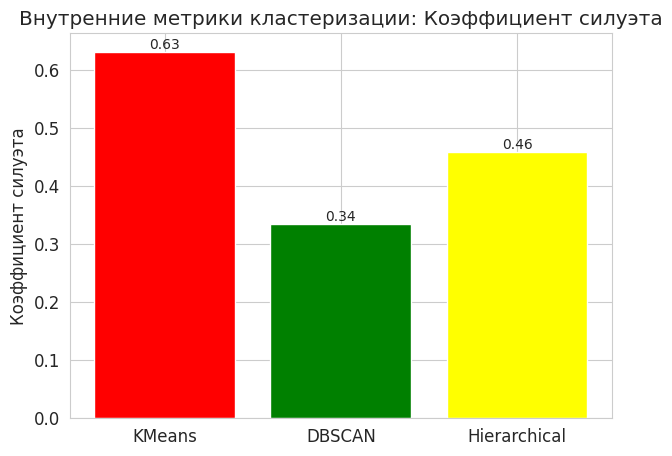

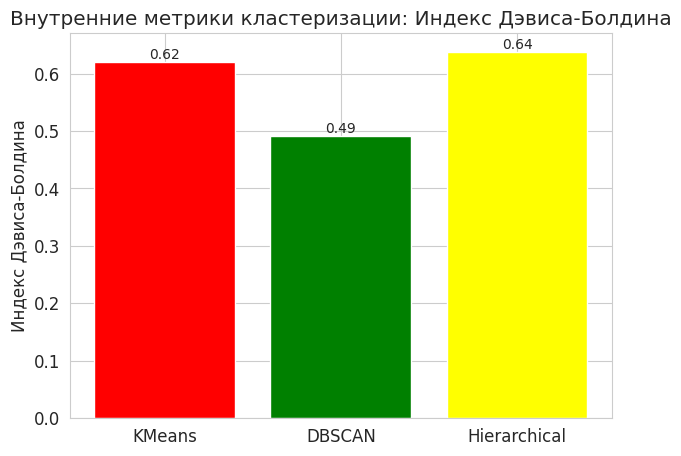

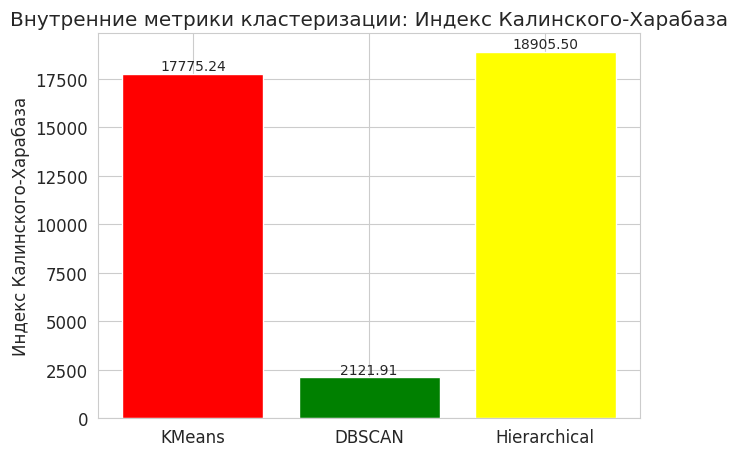

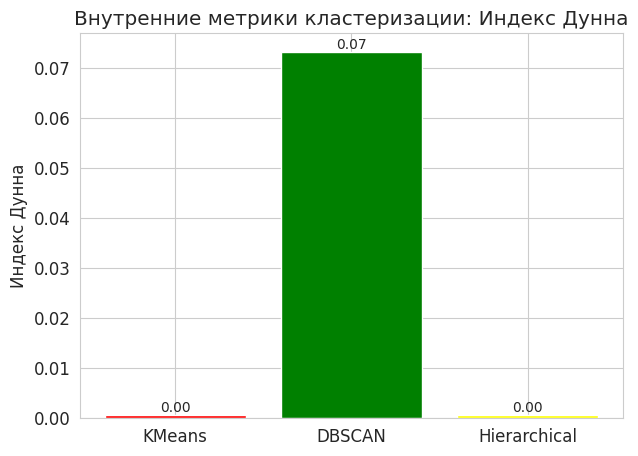

In [ ]:
# Визуализация метрик
def plot_metrics(metrics, title):
    algorithms = list(metrics.keys())
    metrics_names = list(metrics[algorithms[0]].keys())

    colors = ['red', 'green', 'yellow', 'blue']

    for metric in metrics_names:
        values = [metrics[algo][metric] for algo in algorithms]
        plt.figure(figsize=(7, 5))


        plt.bar(algorithms, values, color=colors[:len(algorithms)])

        # Добавление меток над столбцами
        for i, value in enumerate(values):
            if not np.isnan(value):
                plt.text(i, value, f'{value:.2f}', ha='center', va='bottom', fontsize=10)

        plt.title(f"{title}: {metric}")
        plt.ylabel(metric)
        plt.show()

# Построение графиков для внутренних метрик
plot_metrics(metrics_results, 'Внутренние метрики кластеризации')

#### **Шаг 5: Интерпретация и визуализация результатов**

**5.1. Визуализация кластеров:**

- **Снижение размерности:** Примените PCA или t-SNE для отображения данных в 2D или 3D пространстве.
- **Постройте графики:**
  - Рассеивания с цветовой кодировкой кластеров.
  - Дендрограммы для иерархической кластеризации.
- **Визуализация признаков:**
  - Постройте боксплоты, гистограммы или тепловые карты для сравнения признаков между кластерами.

**5.2. Описание сегментов:**

- Для каждого кластера опишите характерные черты:
  - Средние значения признаков.
  - Поведенческие особенности (например, частота покупок, средний чек).
  - Демографические характеристики (если доступны).
- Присвойте сегментам осмысленные названия (например, "Лояльные клиенты", "Покупатели со сниженной активностью", "Большие транзакции").

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [ ]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_sampled)

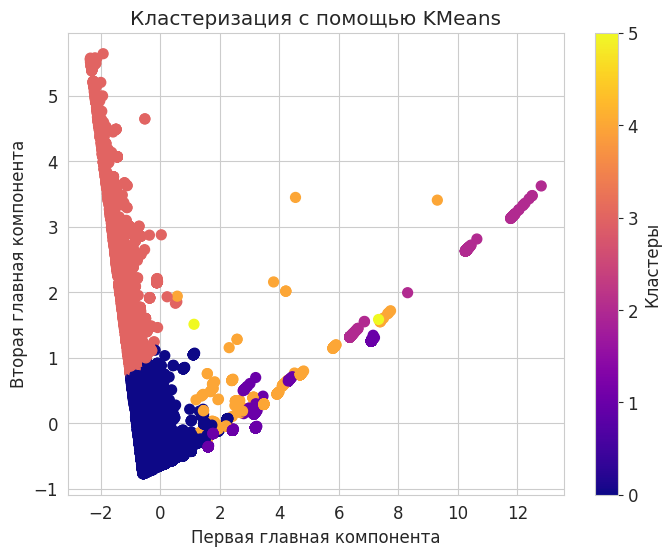

In [ ]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=kmeans_labels, cmap='plasma', s=50)
plt.title('Кластеризация с помощью KMeans')
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.colorbar(label='Кластеры')
plt.show()

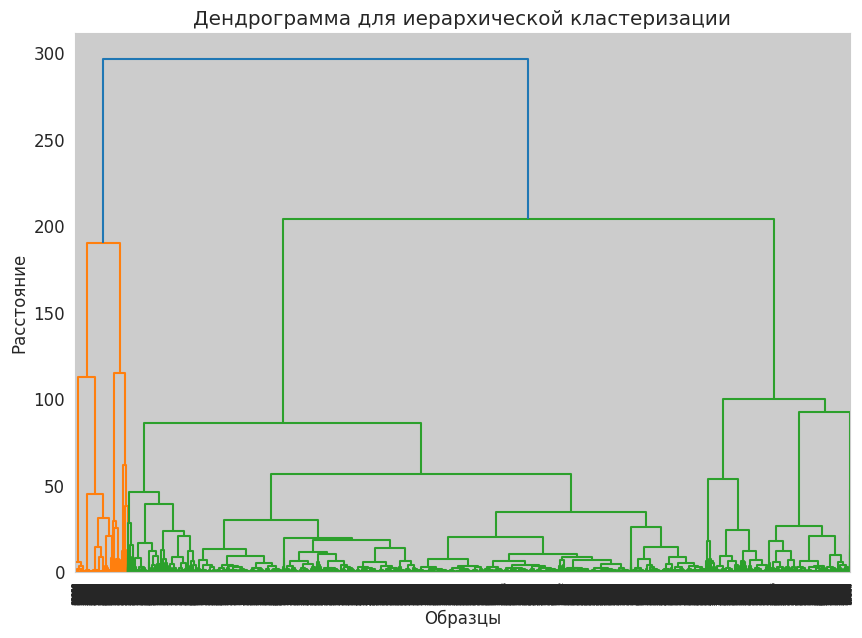

In [ ]:
# 2. Дендрограмма для иерархической кластеризации
linked = linkage(X_sampled, method='ward')

plt.figure(figsize=(10, 7))
dendrogram(linked)
plt.title('Дендрограмма для иерархической кластеризации')
plt.xlabel('Образцы')
plt.ylabel('Расстояние')
plt.show()

<ipython-input-58-edc9adf12972>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=kmeans_labels, y=X_sampled[feature], palette='Set2')
<ipython-input-58-edc9adf12972>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=kmeans_labels, y=X_sampled[feature], palette='Set2')
<ipython-input-58-edc9adf12972>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=kmeans_labels, y=X_sampled[feature], palette='Set2')
<ipython-input-58-edc9adf12972>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0.

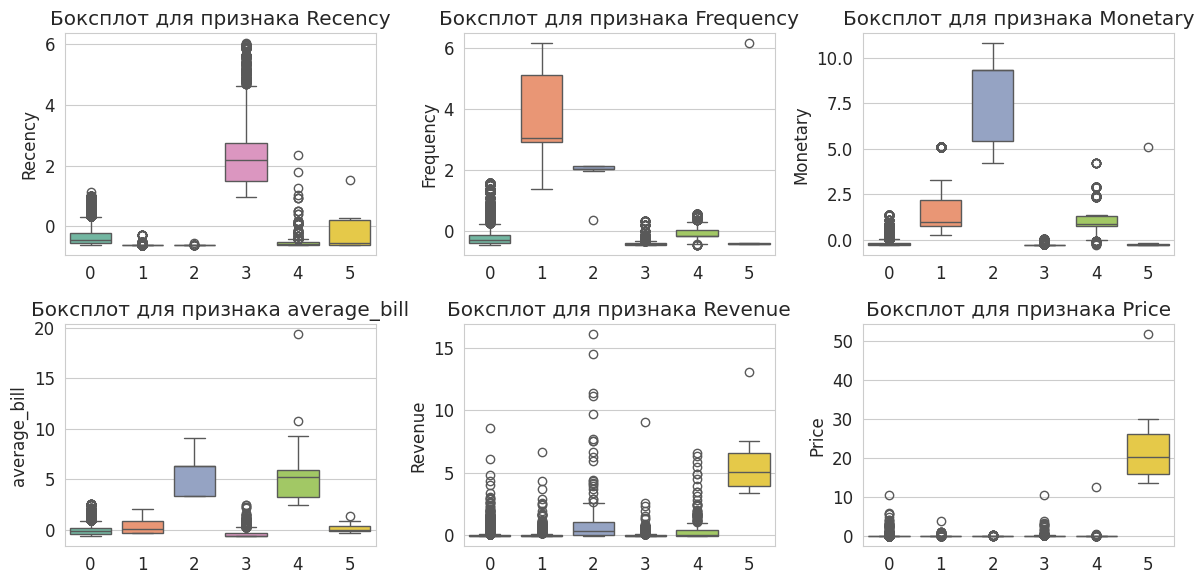

In [ ]:
# 3. Визуализация признаков с помощью боксплотов
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.boxplot(x=kmeans_labels, y=X_sampled[feature], palette='Set2')
    plt.title(f'Боксплот для признака {feature}')
plt.tight_layout()
plt.show()


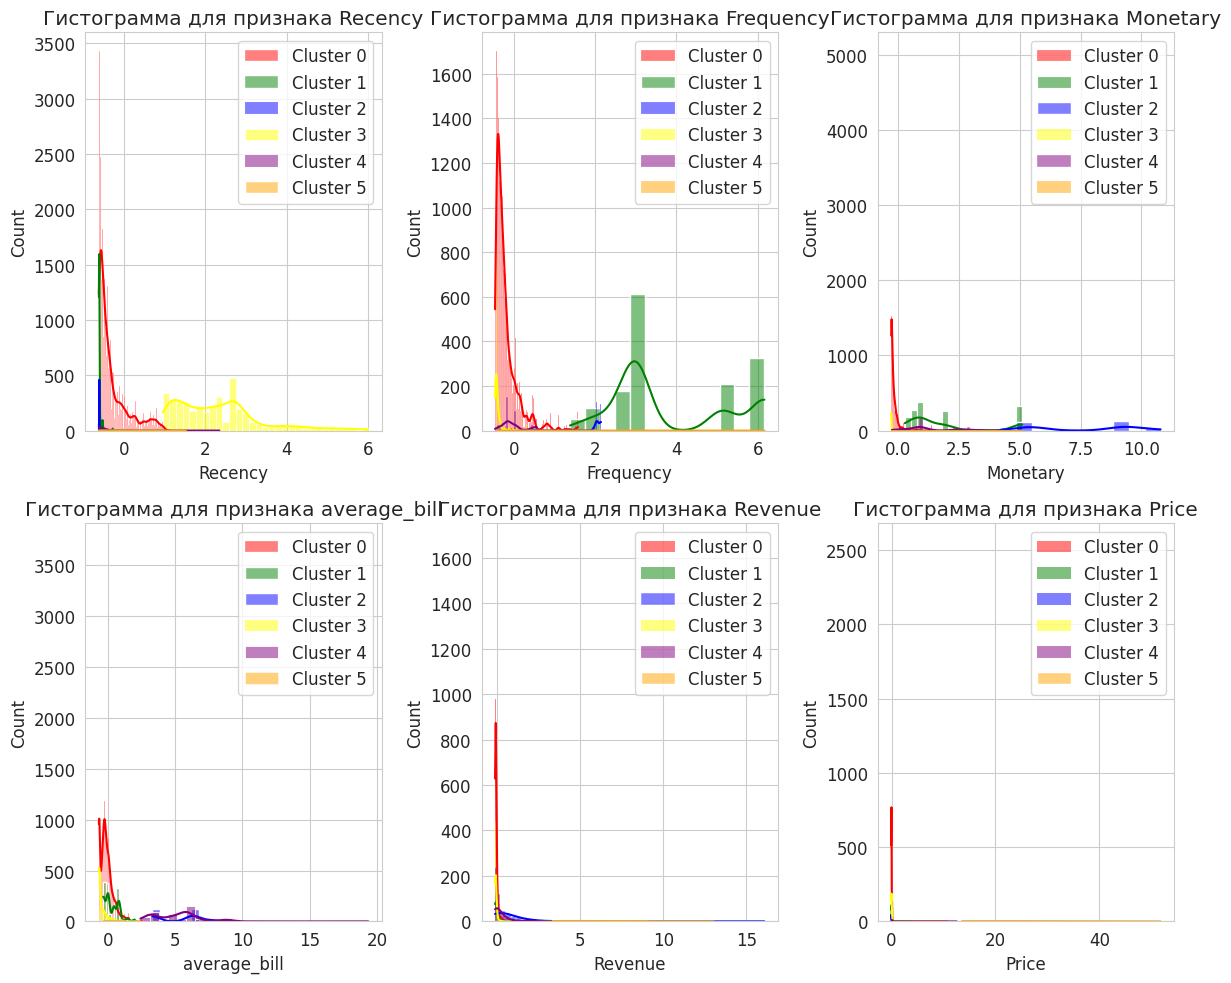

In [ ]:
# 4. Гистограммы для признаков между кластерами
plt.figure(figsize=(12, 10))
for i, feature in enumerate(features):
    plt.subplot(2, 3, i+1)
    sns.histplot(X_sampled[feature][kmeans_labels == 0], color='red', label='Cluster 0', kde=True)
    sns.histplot(X_sampled[feature][kmeans_labels == 1], color='green', label='Cluster 1', kde=True)
    sns.histplot(X_sampled[feature][kmeans_labels == 2], color='blue', label='Cluster 2', kde=True)
    sns.histplot(X_sampled[feature][kmeans_labels == 3], color='yellow', label='Cluster 3', kde=True)
    sns.histplot(X_sampled[feature][kmeans_labels == 4], color='purple', label='Cluster 4', kde=True)
    sns.histplot(X_sampled[feature][kmeans_labels == 5], color='orange', label='Cluster 5', kde=True)
    plt.title(f'Гистограмма для признака {feature}')
    plt.legend()
plt.tight_layout()
plt.show()

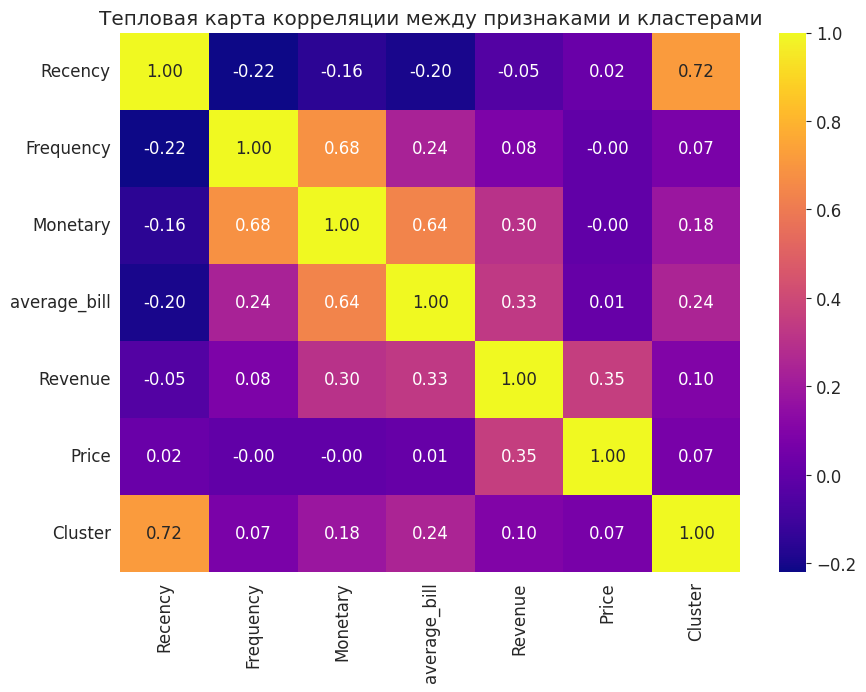

In [ ]:
# 5. Тепловая карта для корреляции признаков между кластерами
df_sampled = pd.DataFrame(X_sampled, columns=features)
df_sampled['Cluster'] = kmeans_labels

plt.figure(figsize=(10, 7))
correlation_matrix = df_sampled.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='plasma', fmt='.2f', cbar=True)
plt.title('Тепловая карта корреляции между признаками и кластерами')
plt.show()

In [ ]:
import pandas as pd

df_sampled['Description'] = df['Description']
df_sampled['preferred_category'] = df['preferred_category']
df_sampled['kmeans_cluster'] = kmeans_labels

# Функция для описания сегментов
def describe_kmeans_clusters(df, features, cluster_column):
    cluster_description = df.groupby(cluster_column)[features].mean()

    cluster_description['Средняя частота покупок'] = df.groupby(cluster_column)['Frequency'].mean()
    cluster_description['Средний чек'] = df.groupby(cluster_column)['average_bill'].mean()

    cluster_description['Предпочитаемая категория'] = df.groupby(cluster_column)['preferred_category'] \
        .apply(lambda x: x.mode()[0] if not x.mode().empty else 'Неопределено')

    if 'Age' in df.columns:
        cluster_description['Средний возраст'] = df.groupby(cluster_column)['Age'].mean()
    if 'Income' in df.columns:
        cluster_description['Средний доход'] = df.groupby(cluster_column)['Income'].mean()

    return cluster_description

# Описание кластеров
features = ['Recency', 'Frequency', 'Monetary', 'average_bill', 'Revenue', 'Price']
kmeans_description = describe_kmeans_clusters(df_sampled, features, 'kmeans_cluster')


original_means = scaler.mean_  # Средние значения исходных данных
original_std = scaler.scale_   # Стандартные отклонения исходных данных

kmeans_description_original = kmeans_description.copy()
for feature, mean, std in zip(features, original_means, original_std):
    kmeans_description_original[feature] = (kmeans_description[feature] * std) + mean


description_file_path = 'kmeans_segments_description.xlsx'
kmeans_description_original.to_excel(description_file_path, index=True)


In [ ]:
print("Описание кластеров K-Means в исходном масштабе:")
kmeans_description_original

Описание кластеров K-Means в исходном масштабе:


,Recency,Frequency,Monetary,average_bill,Revenue,Price,Средняя частота покупок,Средний чек,Предпочитаемая категория
kmeans_cluster,,,,,,,,,
0,34.866883,16.803442,6102.040751,277.566994,16.732428,3.446123,-0.197870,-0.106964,WORLD WAR 2 GLIDERS ASSTD DESIGNS
1,1.636856,261.539973,125187.961592,462.324331,24.074722,3.162419,3.862625,0.263314,DISCO BALL CHRISTMAS DECORATION
2,0.920290,153.800725,443483.896667,2906.868904,213.697174,2.650290,2.075092,5.162499,DOLLY GIRL LUNCH BOX
3,324.099652,4.947227,989.793151,119.285790,13.272976,4.720991,-0.394580,-0.424180,ASSTD DESIGN BUBBLE GUM RING
4,15.854626,28.312775,79949.069339,2886.201748,89.443150,4.377863,-0.006916,5.121079,LIPSTICK PEN RED
5,62.285714,61.000000,43938.417143,439.354795,1250.895714,1250.895714,0.535408,0.217280,60 CAKE CASES VINTAGE CHRISTMAS


from matplotlib import pyplot as plt
kmeans_description_original['Recency'].plot(kind='hist', bins=20, title='Recency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
kmeans_description_original['Frequency'].plot(kind='hist', bins=20, title='Frequency')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
kmeans_description_original['Monetary'].plot(kind='hist', bins=20, title='Monetary')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
kmeans_description_original['average_bill'].plot(kind='hist', bins=20, title='average_bill')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
kmeans_description_original.groupby('Предпочитаемая категория').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
kmeans_description_original.plot(kind='scatter', x='Recency', y='Frequency', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
kmeans_description_original.plot(kind='scatter', x='Frequency', y='Monetary', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
kmeans_description_original.plot(kind='scatter', x='Monetary', y='average_bill', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
kmeans_description_original.plot(kind='scatter', x='average_bill', y='Revenue', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
kmeans_description_original['Recency'].plot(kind='line', figsize=(8, 4), title='Recency')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
kmeans_description_original['Frequency'].plot(kind='line', figsize=(8, 4), title='Frequency')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
kmeans_description_original['Monetary'].plot(kind='line', figsize=(8, 4), title='Monetary')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
kmeans_description_original['average_bill'].plot(kind='line', figsize=(8, 4), title='average_bill')
plt.gca().spines[['top', 'right']].set_visible(False)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(kmeans_description_original['Предпочитаемая категория'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(kmeans_description_original, x='Recency', y='Предпочитаемая категория', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(kmeans_description_original['Предпочитаемая категория'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(kmeans_description_original, x='Frequency', y='Предпочитаемая категория', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(kmeans_description_original['Предпочитаемая категория'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(kmeans_description_original, x='Monetary', y='Предпочитаемая категория', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

<string>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.



from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(kmeans_description_original['Предпочитаемая категория'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(kmeans_description_original, x='average_bill', y='Предпочитаемая категория', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)

In [ ]:
# Анализ распределения по товарам
top_descriptions = df_sampled.groupby(['kmeans_cluster', 'Description']) \
    .size() \
    .reset_index(name='count') \
    .sort_values(['kmeans_cluster', 'count'], ascending=[True, False]) \
    .groupby('kmeans_cluster') \
    .head(3)

print("Топ-3 товаров для каждого кластера:")
top_descriptions


Топ-3 товаров для каждого кластера:


,kmeans_cluster,Description,count
3490,0,WHITE HANGING HEART T-LIGHT HOLDER,137
2585,0,REGENCY CAKESTAND 3 TIER,91
206,0,ASSORTED COLOUR BIRD ORNAMENT,79
4366,1,REGENCY CAKESTAND 3 TIER,8
4617,1,WHITE HANGING HEART T-LIGHT HOLDER,7
4633,1,WOOD S/3 CABINET ANT WHITE FINISH,7
4831,2,RED TOADSTOOL LED NIGHT LIGHT,3
4842,2,ROUND SNACK BOXES SET OF4 WOODLAND,3
4657,2,20 DOLLY PEGS RETROSPOT,2
6665,3,WHITE HANGING HEART T-LIGHT HOLDER,20


Recency (давность): Время с момента последней покупки.

Frequency (частота): Количество покупок за определенный период.

Monetary (сумма): Общая сумма покупок.

average_bill: средний чек

#### **Шаг 6: Формирование бизнес-рекомендаций**

**6.1. Анализ потребностей каждого сегмента:**

- Определите потребности и предпочтения клиентов в каждом сегменте.
- Выявите возможности для увеличения продаж и улучшения сервиса.

**6.2. Разработка стратегий для каждого сегмента:**

- **Маркетинговые кампании:**
  - Персонализированные предложения.
  - Программы лояльности для удержания ценных клиентов.
- **Оптимизация продуктов:**
  - Расширение ассортимента для популярных сегментов.
  - Фокус на продуктах, интересных конкретным сегментам.

**6.3. Оценка потенциального влияния:**

- Оцените, как предложенные стратегии могут повысить выручку, удовлетворенность клиентов и другие ключевые показатели.

# <font color='red'>ВАШ ОТВЕТ</font>

#### **Шаг 7: Документирование и презентация результатов**

**7.1. Подготовка отчета:**

- **Введение:**
  - Описание цели работы и её значимости для бизнеса.
- **Методология:**
  - Подробное описание проведенных шагов.
- **Результаты:**
  - Представление метрик оценки и визуализаций.
  - Описание сегментов клиентов.
- **Обсуждение:**
  - Анализ полученных результатов.
  - Сравнение алгоритмов и обоснование выбора.
- **Рекомендации:**
  - Предложения по внедрению результатов в бизнес-процессы.
- **Заключение:**
  - Выводы о проделанной работе и её значимости.

**7.2. Презентация:**

- Подготовьте слайды для представления ключевых моментов работы.
- Используйте визуализации для иллюстрации результатов.
- Готовьтесь ответить на вопросы аудитории.

**7.3. Код и reproducibility:**

- Организуйте код в репозитории (например, GitHub) с понятной структурой.
- Приложите инструкции для воспроизведения результатов.

